**Step 1: Import packages**

In [20]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import kerastuner as kt
import IPython

# sklearn libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# sklearn libraries for models
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner import Hyperband

# sklearn libraries for evaluation
from sklearn import metrics

**Step 2: Define working directories**

In [21]:
os.chdir('C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project')

**Step 3: Define classes**

In [22]:
# Clear the training outputs at the end of every step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        '''Clear the training outputs at the end of every step for the Keras Tuner'''
        IPython.display.clear_output(wait = True)

**Step 4: Define functions**

In [23]:
def reduce(X, n):
    '''PCA dimensionality reduction for X array and n principal components'''
    pca = PCA(n_components = n) 
    X_reduced = pca.fit_transform(X)
    return X_reduced

In [24]:
def data_split(X, y, test_p, mini_s):
    '''Split train and test data for X,y data arrays with test_p percentage of observations in the test data and 
    mini_s number of observations in the mini_train set.'''
    # Split into train and test data
    train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=test_p, random_state=1, stratify=y)

    # Split test data into development data and training into mini train set for computation time
    dev_data, dev_labels = test_data[:int(test_data.shape[0]*0.5)], test_labels[:int(test_data.shape[0]*0.5)]
    mini_train_data, mini_train_labels = train_data[:mini_s], train_labels[:mini_s]
    print('Train data shape:', train_data.shape)
    print('Dev data shape:', dev_data.shape)
    print('Mini_train data shape:', mini_train_data.shape)
    
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels

In [25]:
def log_reg(train_X, train_Y, dev_X, dev_Y):
    '''Logistic regression looping through values of C. Input train and test data and labels and funtion 
    returns list of accuracies and list of C values.'''
    c_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0]
    LR = []
    for c in c_values:
        clf = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        clf.fit(train_X, train_Y)
        clf_pred = clf.predict(dev_X)
        LR.append(round(metrics.f1_score(dev_Y, clf_pred, average='weighted'),3))

    return LR, c_values

In [26]:
def LR_accuracy_c(train_X, train_Y, dev_X, dev_Y):
    '''Calls logistic regression function and returns highest accuracy for specific value of C.'''
    accuracy_list = log_reg(train_X, train_Y, dev_X, dev_Y)[0]
    accuracy = [y for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    accuracy_index = [x for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    C = log_reg(train_X, train_Y, dev_X, dev_Y)[1][accuracy_index[0]]
    
    return accuracy[0], C

In [27]:
def PCA_visualization(pca_vals, title, colors):
    x = [item[0] for item in pca_vals] 
    y = [item[1] for item in pca_vals] 

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.scatter(x, y, c=colors, s = 5)
    ax.grid()

In [28]:
def PCA_k_optimize(train_X, train_Y, dev_X, dev_Y, k_list):
    accuracies = []
    c_vals = []
    # Subset pixel data
    train_pixel = train_X[:, :150529]
    dev_pixel = dev_X[:, :150529]
    train_nopixel = train_X[:, 150529:]
    dev_nopixel = dev_X[:, 150529:]
    for k in k_list:
        #Scale and reduce only pixel data
        ss = StandardScaler()
        train_pixel_s = ss.fit_transform(train_pixel)
        dev_pixel_s = ss.transform(dev_pixel)
        pca = PCA(n_components = k) 
        train_pixel_reduced = pca.fit_transform(train_pixel_s)
        dev_pixel_reduced = pca.transform(dev_pixel_s)
        #Concatenate reduced pixel data back with non pixel data
        train_X_new = np.concatenate((train_nopixel, train_pixel_reduced), axis=1)
        dev_X_new = np.concatenate((dev_nopixel, dev_pixel_reduced), axis=1)
        #Obtain accuracy and optimized c value
        results = LR_accuracy_c(train_X_new, train_Y, dev_X_new, dev_Y)
        accuracies.append(results[0])
        c_vals.append(results[1])
    return accuracies, c_vals

In [66]:
def model_builder(hp):
    '''Build a single layer dense neural network using Keras Tuner'''
    model = keras.Sequential()
  
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    
    model.add(keras.layers.Dense(2, activation = 'softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
    return model

In [109]:
def build_model(nodes, dropout_rate, lr):
    '''Build layers of a neural net'''
    
    # Begins the linear arrangment of layers
    model = tf.keras.models.Sequential([

    # First layer 
    # This is a dense layer. Nodes are fully connected.
    # Nodes is the number of nodes in the layer. This will be specified when calling the function.
    tf.keras.layers.Dense(nodes, activation='relu'),

    # Second layer
    # Uses dropout regularization by dropping a certain percentage before next layer
    # This makes it so that some of the nodes in a given layer don’t pass on their information to the next layer. 
    # This helps with computation time (less parameters) and with overfitting.
    # Each node in the second  layer has a probability equal to the specified dropout rate of being dropped from the computation of the activations of the next layer. 
    tf.keras.layers.Dropout(dropout_rate),
    
    # Third layer
    # This is the output layer. It returns a logits array of length 2 (because we have 2 classes - logo or not logo)
    # Each node contains a probability that indicates the current image belongs to one of the 2 classes
    # It uses the activation function Softmax which is the equivalent of the Sigmoid function for multiclass logits
    tf.keras.layers.Dense(2, activation='softmax')])
    
    # Compile the model using the Adam optimizer
    # The learning rate will be specified when the function is called
    model.compile(keras.optimizers.Adam(learning_rate = lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [31]:
# Fit the neural net model
# Specify the number of epochs
def fit_model(model, data, labels, epoch_num):
    history = model.fit(data, labels, epochs = epoch_num)
    return history

In [32]:
# Evaluate the neural net model
def evaluate_model(model, data, labels):
    test_loss, test_acc = model.evaluate(data, labels)
    return test_acc

**Step 5: Read data**

5.1 Load and combine pixel data files into dataframe

In [33]:
# Load npz files to combine and print content files
data_1 = np.load('et_w207_project_npz_files_5000_tmp_tmp5ocrhjnn.npz')
data_1.close

data_2 = np.load('et_w207_project_npz_files_5000_tmp_tmp092sag67.npz')
data_2.close

data_3 = np.load('et_w207_project_npz_files_5000_tmp_tmpf31_pn8p.npz')
data_3.close

data_4 = np.load('et_w207_project_npz_files_5000_tmp_tmpq5b2g4n2.npz')
data_4.close

print(data_1.files)

['arr_0', 'arr_1']


In [34]:
# Show file arr_0 example
data_1['arr_0'][:5]

array(['ozbpir-9ey6js-ggdqwo', '378ykanq', 'p366md-big834-7o23k6',
       '3zruwvl2', 'q18iae-3vnh74-79npmy'], dtype='<U20')

In [35]:
# Show file arr_1 example
data_1['arr_1'][:5]

array([[-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ],
       [ -46.939003,  -74.779   , -118.68    , ...,  -57.939003,
         -84.779   , -118.68    ],
       [ 151.061   ,  138.22101 ,  131.32    , ...,  151.061   ,
         138.22101 ,  131.32    ],
       [  -3.939003,  -66.779   ,  -96.68    , ...,   -3.939003,
         -66.779   ,  -96.68    ],
       [-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ]], dtype=float32)

In [36]:
# Get number of observations in each file
print(data_1['arr_0'].shape)
print(data_2['arr_0'].shape)
print(data_3['arr_0'].shape)
print(data_4['arr_0'].shape)

(878,)
(893,)
(638,)
(1353,)


In [37]:
# Concatenate data from all files
data_key = np.concatenate((data_1['arr_0'], data_2['arr_0'], data_3['arr_0'], data_4['arr_0']))

data_pixel = np.concatenate((data_1['arr_1'], data_2['arr_1'], data_3['arr_1'], data_4['arr_1']))
print(data_pixel.shape)

(3762, 150528)


In [38]:
# Create key value pairs with attachment key and pixel array
# Standardize pixel values between 0 and 1 by dividing by 255
# Store pixel data as dataframe
data_dict = {}
for i in range(data_key.shape[0]):
    data_dict[data_key[i]] = [data_pixel[i]/255]

df_pixel = pd.DataFrame(data=data_dict)
df_pixel_t = df_pixel.transpose()
df_pixel_t.index.names = ['attachment_key']
df_pixel_t.columns = ['pixel_array']
df_pixel_t

,pixel_array
attachment_key,
ozbpir-9ey6js-ggdqwo,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
378ykanq,"[-0.18407452, -0.29325098, -0.46541175, -0.097..."
p366md-big834-7o23k6,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3zruwvl2,"[-0.015447071, -0.26187843, -0.37913725, -0.01..."
q18iae-3vnh74-79npmy,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
...,...
pktyig-481wyg-6gyulf,"[-0.3605451, -0.41089803, -0.38305882, -0.3644..."
zu7y3rha,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
pxcwxf-8tnpyg-8vhb9r,"[0.3022, 0.18125883, 0.12674509, 0.31004313, 0..."


5.2 Load metadata file

In [39]:
# Load excel data
df = pd.read_csv('school_project_data_set-new.csv')
df.head()

,attachment_key,size_mb,height,width,h_to_w,filename,logo
0,001lq61k,0.122520,514.0,720.0,0.713889,campus ministry on the beach.jpg,0
1,002dlirq,3.256944,4072.0,3868.0,1.052741,BIG ALS FISH FLASH UV VP PL.jpg,0
2,003qefgm,0.002522,80.0,200.0,0.400000,netix_email_studio.png,1
3,0083okjl,0.116802,600.0,600.0,1.000000,productshot2.jpg,0
4,00a957mh,0.140714,816.0,2382.0,0.342569,divine_medical_billing_inc_master.png,1


5.3 Combine pixel and metadata features in a pandas dataframe

In [40]:
# Merge dataframes by attachment key
combined_df = df.merge(df_pixel_t, on='attachment_key')
combined_df

,attachment_key,size_mb,height,width,h_to_w,filename,logo,pixel_array
0,00xjny6u,0.011849,520.0,506.0,1.027668,Esterdale Theatre - Logo.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
1,04o31jop,0.012610,269.0,396.0,0.679293,BLUE_LOGO.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
2,0840h7ox,0.399114,518.0,920.0,0.563044,ZEN_LB-5.jpg,0,"[0.106121555, 0.05576863, 0.052235294, 0.09043..."
3,0awudx2h,0.011226,200.0,200.0,1.000000,article central 200.jpg,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
4,0bb8y85h,0.263813,885.0,800.0,1.106250,1116-100_WGTank_white.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
...,...,...,...,...,...,...,...,...
3750,zu7y3rha,0.147371,498.0,702.0,0.709402,journalism.jpg,0,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
3751,zuanbsqe,0.580392,206.0,415.0,0.496386,2013 05 26_techstars_id_final_bug solo graysca...,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3752,zw9234v4,2.021135,1645.0,1450.0,1.134483,SPIN N GLO SILVER WING GPK MY.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3753,zxfqbfj1,0.012057,36.0,345.0,0.104348,cornerstone web logo medium.png,1,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."


In [41]:
### VISUALIZATIONS FROM PANDAS PROFILING HERE

**Step 6: Data preprocessing**

6.1 Remove null values

In [42]:
# Remove rows with null values
combined_df = combined_df[combined_df.height.notnull()]
combined_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attachment_key  3754 non-null   object 
 1   size_mb         3754 non-null   float64
 2   height          3754 non-null   float64
 3   width           3754 non-null   float64
 4   h_to_w          3754 non-null   float64
 5   filename        3754 non-null   object 
 6   logo            3754 non-null   int64  
 7   pixel_array     3754 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 264.0+ KB


6.2 Create file type dummy variables from file name

In [43]:
# Find file types from filename
file_types = []
for item in combined_df['filename']:
    file_types.append(item[-3:].lower())

print(set(file_types))

{'hot', 'jpg', '0mm', 'age', 'peg', 'ite', 'png', 'ack', 'jpe', 'pig', '73e', 'lue'}


In [44]:
# Create list of file types from filename to append to df
filetype_encoding = []
for item in combined_df['filename']:
    if item[-3:].lower() == 'jpg':
        filetype_encoding.append('jpg')
    elif item[-3:].lower() == 'png':
        filetype_encoding.append('png')
    else:
        filetype_encoding.append('other')

In [45]:
# Create df that includes column for file type
combined_df['filetype'] = filetype_encoding
combined_df = combined_df[['attachment_key', 'size_mb', 'height', 'width', 'h_to_w', 'filetype', 'pixel_array', 'filename','logo']]
combined_df.head()
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

/Users/alyssaaugsburger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0


In [46]:
# Get dummies for file type
filetype_dummies = pd.get_dummies(combined_df.filetype)

# add to initial df
combined_df = pd.concat((combined_df, filetype_dummies), axis=1)

# print head of df
combined_df.head()

,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo,jpg,other,png
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1,0,0,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1,0,0,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0,1,0,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1,1,0,0
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0,1,0,0


6.3 Scale metadata variables

In [47]:
# Scale continuous feature variables
combined_df['size_mb'] = preprocessing.scale(combined_df['size_mb'])
combined_df['h_to_w'] = preprocessing.scale(combined_df['h_to_w'])
combined_df['height'] = preprocessing.scale(combined_df['height'])
combined_df['width'] = preprocessing.scale(combined_df['width'])

6.4 Create X, y arrays

In [48]:
# Organize df to separate into feature arrays
combined_df = combined_df[['attachment_key', 'pixel_array', 'size_mb', 'h_to_w', 'jpg', 'png', 'other',
                                     'height', 'width', 'logo', 'filetype', 'filename']]
combined_df.head()

,attachment_key,pixel_array,size_mb,h_to_w,jpg,png,other,height,width,logo,filetype,filename
0,00xjny6u,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366308,0.638439,0,1,0,-0.712708,-0.888611,1,png,Esterdale Theatre - Logo.png
1,04o31jop,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366187,-0.187892,0,1,0,-0.861519,-0.943446,1,png,BLUE_LOGO.png
2,0840h7ox,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",-0.304882,-0.463630,1,0,0,-0.713894,-0.682232,0,jpg,ZEN_LB-5.jpg
3,0awudx2h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366407,0.572811,1,0,0,-0.902427,-1.041152,1,jpg,article central 200.jpg
4,0bb8y85h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.326343,0.824832,1,0,0,-0.496310,-0.742052,0,jpg,1116-100_WGTank_white.jpg


In [49]:
# y array contains logo/not logo binary variable
y = np.array(combined_df.iloc[:, 9])

# X array contains pixel array only
X = np.array(combined_df['pixel_array'].tolist())
print(X.shape)


(3754, 150528)


In [50]:
# Reduce dimensionality of pixel array
ss_pixel = StandardScaler()
XS = ss_pixel.fit_transform(X)
pixel_reduced = reduce(XS,2)
X_reduced = pixel_reduced

# Reduce dimensionality of non-pixel data
nopixel_X = np.array(combined_df.iloc[:, 2:7].values)
ss_nopixel = StandardScaler()
nopixel_XS = ss_nopixel.fit_transform(nopixel_X)
nopixel_reduced = reduce(nopixel_XS,2)

# Reduce dimensionality of pixel and non-pixel data
combined_X = np.concatenate((nopixel_X, X), axis = 1)
ss_combined = StandardScaler()
combined_XS = ss_nopixel.fit_transform(combined_X)
combined_reduced = reduce(combined_XS,2)

colors = ['r' if label == 0 else 'g' for label in y]

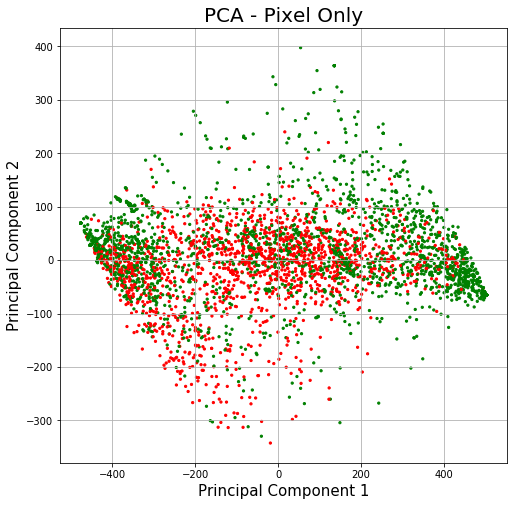

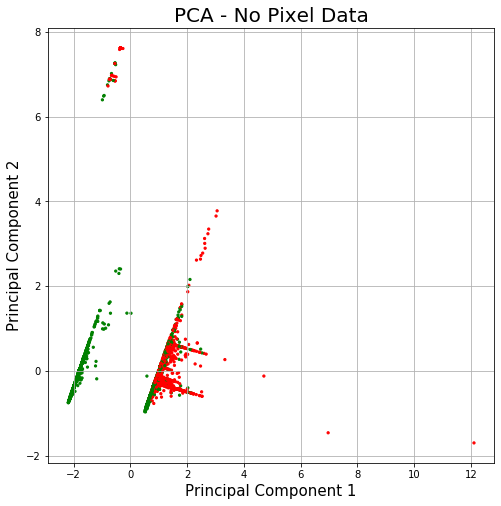

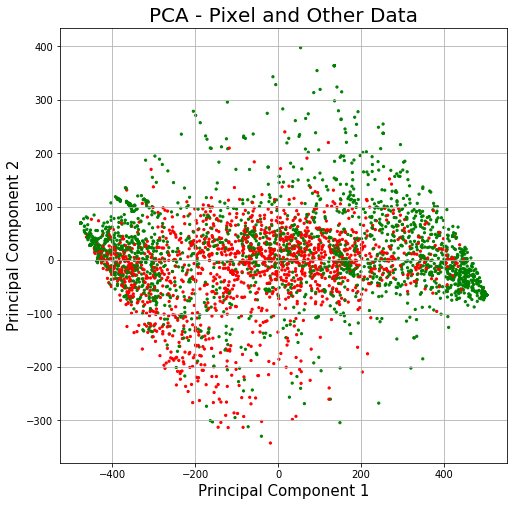

In [31]:
PCA_visualization(pixel_reduced,'PCA - Pixel Only', colors)
PCA_visualization(nopixel_reduced,'PCA - No Pixel Data', colors)
PCA_visualization(combined_reduced,'PCA - Pixel and Other Data', colors)


6.6 Create alternate X arrays with metadata features

In [51]:
# Create variations of X array with reduced pixel data and different metadata features

# X2 array contains pixel features, size, height, width, h_to_w, filetype dummies
X2 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 2:9])),axis=1)
print(X2.shape)

# X3 array contains pixel features, size, h_to_w, filetype dummies
X3 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 2:7])),axis=1)
print(X3.shape)

# X4 array contains pixel array, size, h_to_w
X4 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 2:4])),axis=1)
print(X4.shape)

# X5 array contains pixel array, filetype dummies 
X5 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 4:7])),axis=1)
print(X5.shape)

# X6 array contains size, height, width, h_to_w, filetype
X6 = np.array(combined_df.iloc[:, 2:9])
print(X6.shape)

# X7 array contains size, h_to_w, filetype
X7 = np.array(combined_df.iloc[:, 2:7])
print(X7.shape)

# X8 array contains full pixel array, size, h_to_w, filetype
X8 = np.concatenate((X, X7), axis=1)
print(X8.shape)

(3754, 9)
(3754, 7)
(3754, 4)
(3754, 5)
(3754, 7)
(3754, 5)
(3754, 150533)


6.7 Split each set of features into train, development, and test data

In [52]:
# Split all feature combinations into train, test data
train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels = data_split(X_reduced, y, 0.4, 100)
train_data2, train_labels2, test_data2, test_labels2, dev_data2, dev_labels2, mini_train_data2, mini_train_labels2 = data_split(X2, y, 0.4, 100)
train_data3, train_labels3, test_data3, test_labels3, dev_data3, dev_labels3, mini_train_data3, mini_train_labels3 = data_split(X3, y, 0.4, 100)
train_data4, train_labels4, test_data4, test_labels4, dev_data4, dev_labels4, mini_train_data4, mini_train_labels4 = data_split(X4, y, 0.4, 100)
train_data5, train_labels5, test_data5, test_labels5, dev_data5, dev_labels5, mini_train_data5, mini_train_labels5 = data_split(X5, y, 0.4, 100)
train_data6, train_labels6, test_data6, test_labels6, dev_data6, dev_labels6, mini_train_data6, mini_train_labels6 = data_split(X6, y, 0.4, 100)
train_data7, train_labels7, test_data7, test_labels7, dev_data7, dev_labels7, mini_train_data7, mini_train_labels7 = data_split(X7, y, 0.4, 100)
train_data8, train_labels8, test_data8, test_labels8, dev_data8, dev_labels8, mini_train_data8, mini_train_labels8 = data_split(X8, y, 0.4, 100)

Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 9)
Dev data shape: (751, 9)
Mini_train data shape: (100, 9)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 4)
Dev data shape: (751, 4)
Mini_train data shape: (100, 4)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)
Train data shape: (2252, 150533)
Dev data shape: (751, 150533)
Mini_train data shape: (100, 150533)


**Step 7: Logistic Regression**

7.1 Run logistic regression for pixel data only

In [34]:
# Pixel array only
# Run LR and output best accuracy with c value
print('Features: pixel features only\nBest Accuracy: {}, c={}'.format(
    LR_accuracy_c(train_data, train_labels, dev_data, dev_labels)[0],
    LR_accuracy_c(train_data, train_labels, dev_data, dev_labels)[1]))

Features: pixel features only
Best Accuracy: 0.583, c=0.001


7.2 Run logistic regression for all feature combinations

In [35]:
# Run LR and output best accuracies with c values for each combination of features
print('Features: pixel features, size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)[0],
    LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)[1]))

print('Features: pixel features, size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)[0],
    LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)[1]))

print('Features: pixel features, size, h_to_w\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)[0],
    LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)[1]))

print('Features: pixel features, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)[0],
    LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)[1]))

print('Features: size, height, width, h_to_w, filetype\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)[0],
    LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)[1]))

print('Features: size, h_to_w, filetype\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data7, train_labels7, dev_data7, dev_labels7)[0],
    LR_accuracy_c(train_data7, train_labels7, dev_data7, dev_labels7)[1]))

Features: pixel features, size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.857, c=0.1

Features: pixel features, size, h_to_w, filetype dummies
Best Accuracy: 0.852, c=0.3

Features: pixel features, size, h_to_w
Best Accuracy: 0.768, c=0.3

Features: pixel features, filetype dummies
Best Accuracy: 0.82, c=0.1

Features: size, height, width, h_to_w, filetype
Best Accuracy: 0.845, c=0.1

Features: size, h_to_w, filetype
Best Accuracy: 0.849, c=0.01



In [54]:
#Determine best k value for PCA of pixel data
k_list = [i for i in range(1,15)]
logreg_results = PCA_k_optimize(train_data8, train_labels8, dev_data8, dev_labels8, k_list)
accuracies = logreg_results[0]
c_vals = logreg_results[1]
max_index = accuracies.index(max(accuracies))
max_acc = accuracies[max_index]
max_c = c_vals[max_index]
max_k = k_list[max_index]
print('Features: pixel array reduced to {0} dimensions, size, h_to_w, filetype\nBest Accuracy: {1}, c={2}\n'.format(max_k, max_acc, max_c))

KeyboardInterrupt: 

In [55]:
# Create new train/test data with optimized k value for pixel data
reduce_pixel_k = reduce(X, max_k)

X9 = np.concatenate((reduce_pixel_k, X7), axis=1)
print(X9.shape)
train_data9, train_labels9, test_data9, test_labels9, dev_data9, dev_labels9, mini_train_data9, mini_train_labels9 = data_split(X9, y, 0.4, 100)

(3754, 6)
Train data shape: (2252, 6)
Dev data shape: (751, 6)
Mini_train data shape: (100, 6)


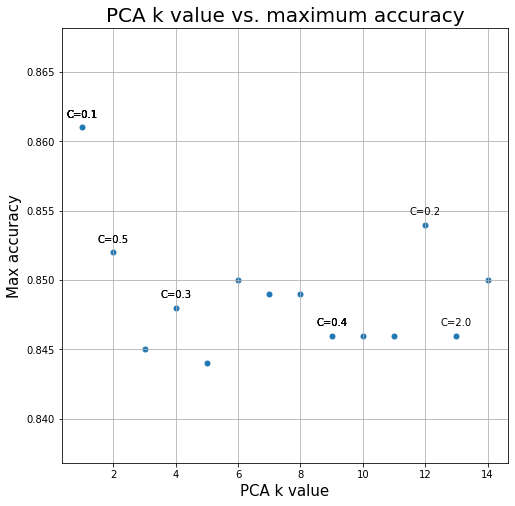

In [38]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA k value', fontsize = 15)
ax.set_ylabel('Max accuracy', fontsize = 15)
ax.set_title("PCA k value vs. maximum accuracy", fontsize = 20)
ax.scatter(k_list, accuracies, s = 25)
for c in c_vals:
    plt.annotate("C={}".format(c), (k_list[c_vals.index(c)], accuracies[c_vals.index(c)]), textcoords="offset points", xytext=(0,10), ha='center')
ax.grid()

**Step 8: Multilayer NN**

8.1 Build a single-layer dense neural network using Keras Tuner so that we can easily tune the hyperparameters.

In [74]:
# Instantiate the tuner to perform hypertuning using the Hyperband tuner and the model_builder function we defined initially.
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project',
                     project_name = 'keras_tuner_results')    

In [75]:
# Run the hyperparameter search
tuner.search(train_data9, train_labels9, epochs = 10, validation_data = (dev_data9, dev_labels9), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Print the results
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.001.



In [76]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_data9, train_labels9, epochs = 10, validation_data = (dev_data9, dev_labels9))

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 0.7996 - accuracy: 0.50 - ETA: 0s - loss: 0.6655 - accuracy: 0.62 - 0s 2ms/step - loss: 0.6582 - accuracy: 0.6337 - val_loss: 0.6182 - val_accuracy: 0.6804
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.71 - ETA: 0s - loss: 0.5493 - accuracy: 0.77 - 0s 1ms/step - loss: 0.5420 - accuracy: 0.7789 - val_loss: 0.5108 - val_accuracy: 0.7976
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.90 - ETA: 0s - loss: 0.5413 - accuracy: 0.77 - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7718 - val_loss: 0.5192 - val_accuracy: 0.8096
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.84 - ETA: 0s - loss: 0.5463 - accuracy: 0.75 - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7615 - val_loss: 0.5120 - val_accuracy: 0.7843
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.78 - ETA: 0s - 

8.2 Build a multi-layer dense neural network.

In [113]:
# Run an intial model using the parameters from the Keras Tuner model and an intial dropout rate of .2
build_model_output = build_model(384, .2, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.56 - ETA: 0s - loss: 1.7258 - accuracy: 0.59 - 0s 1ms/step - loss: 1.6300 - accuracy: 0.6017
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 1.9373 - accuracy: 0.65 - ETA: 0s - loss: 1.1947 - accuracy: 0.67 - 0s 943us/step - loss: 1.1737 - accuracy: 0.6825
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.1524 - accuracy: 0.75 - ETA: 0s - loss: 0.9579 - accuracy: 0.72 - 0s 926us/step - loss: 0.9444 - accuracy: 0.7300
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.0251 - accuracy: 0.62 - ETA: 0s - loss: 0.7984 - accuracy: 0.74 - 0s 950us/step - loss: 0.7878 - accuracy: 0.7433
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.87 - ETA: 0s - loss: 0.7461 - accuracy: 0.76 - 0s 985us/step - loss: 0.7384 - accuracy: 0.7602
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.7283 - accur

71/71 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.84 - ETA: 0s - loss: 0.3574 - accuracy: 0.83 - 0s 908us/step - loss: 0.3458 - accuracy: 0.8481
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.93 - ETA: 0s - loss: 0.3322 - accuracy: 0.85 - 0s 909us/step - loss: 0.3267 - accuracy: 0.8575
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.81 - ETA: 0s - loss: 0.3187 - accuracy: 0.85 - 0s 877us/step - loss: 0.3278 - accuracy: 0.8539
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.93 - ETA: 0s - loss: 0.3315 - accuracy: 0.84 - 0s 876us/step - loss: 0.3317 - accuracy: 0.8481
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.90 - ETA: 0s - loss: 0.3267 - accuracy: 0.85 - 0s 886us/step - loss: 0.3289 - accuracy: 0.8508
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.3455 - accuracy:

8.3 Tune the hyperparameters to try and improve the accuracy.

In [118]:
# Optimize dropout rate
# Loop through dropout rates
dropout_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
final_accuracy_dropout_list = []

for i in dropout_list:
    build_model_output = build_model(384, i, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_dropout_list.append(final_accuracy)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 7.3443 - accuracy: 0.31 - ETA: 0s - loss: 1.6628 - accuracy: 0.59 - 0s 1ms/step - loss: 1.5049 - accuracy: 0.6128
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.0177 - accuracy: 0.62 - ETA: 0s - loss: 0.9255 - accuracy: 0.68 - 0s 1ms/step - loss: 0.9185 - accuracy: 0.6812
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.68 - ETA: 0s - loss: 0.7979 - accuracy: 0.72 - 0s 933us/step - loss: 0.8007 - accuracy: 0.7225
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.75 - ETA: 0s - loss: 0.6825 - accuracy: 0.75 - 0s 976us/step - loss: 0.7443 - accuracy: 0.7438
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.8068 - accuracy: 0.71 - ETA: 0s - loss: 0.7150 - accuracy: 0.75 - 0s 961us/step - loss: 0.6950 - accuracy: 0.7611
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.6737 - accurac

Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.8781 - accuracy: 0.59 - ETA: 0s - loss: 1.5735 - accuracy: 0.67 - 0s 966us/step - loss: 1.5533 - accuracy: 0.6701
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.9520 - accuracy: 0.75 - ETA: 0s - loss: 1.2749 - accuracy: 0.68 - 0s 919us/step - loss: 1.1943 - accuracy: 0.7038
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.65 - ETA: 0s - loss: 0.8656 - accuracy: 0.73 - 0s 897us/step - loss: 0.8592 - accuracy: 0.7358
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.7549 - accuracy: 0.75 - ETA: 0s - loss: 0.7345 - accuracy: 0.74 - 0s 884us/step - loss: 0.7310 - accuracy: 0.7496
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 1.1394 - accuracy: 0.65 - ETA: 0s - loss: 0.6567 - accuracy: 0.76 - 0s 904us/step - loss: 0.6454 - accuracy: 0.7567
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.5915 - acc

71/71 [==============================] - ETA: 0s - loss: 2.3633 - accuracy: 0.59 - ETA: 0s - loss: 2.3228 - accuracy: 0.62 - 0s 992us/step - loss: 2.1708 - accuracy: 0.6217
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 2.2668 - accuracy: 0.65 - ETA: 0s - loss: 1.4265 - accuracy: 0.65 - 0s 1ms/step - loss: 1.3009 - accuracy: 0.6687
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.62 - ETA: 0s - loss: 0.8949 - accuracy: 0.69 - 0s 975us/step - loss: 0.8701 - accuracy: 0.6985
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.84 - ETA: 0s - loss: 0.6873 - accuracy: 0.73 - 0s 964us/step - loss: 0.6831 - accuracy: 0.7260
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.75 - ETA: 0s - loss: 0.5962 - accuracy: 0.74 - 0s 948us/step - loss: 0.5762 - accuracy: 0.7562
Epoch 9/10
71/71 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.81 -

Text(0, 0.5, 'Accuracy')

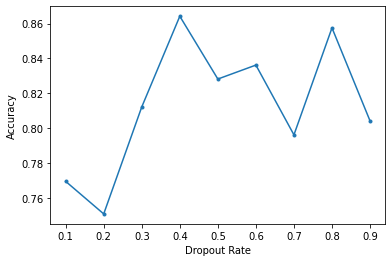

In [119]:
# Graph results
plt.plot(dropout_list, final_accuracy_dropout_list, marker = ".")
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')

In [121]:
# Looks like best dropout rate is .4, so now we will use this
# Run model using optimized dropout rate
build_model_output = build_model(384, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 7.3671 - accuracy: 0.40 - ETA: 0s - loss: 2.8112 - accuracy: 0.58 - 0s 965us/step - loss: 2.6369 - accuracy: 0.5879
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 2.1745 - accuracy: 0.59 - ETA: 0s - loss: 1.7554 - accuracy: 0.66 - 0s 990us/step - loss: 1.6711 - accuracy: 0.6705
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.6687 - accuracy: 0.56 - ETA: 0s - loss: 1.3586 - accuracy: 0.68 - 0s 1ms/step - loss: 1.3545 - accuracy: 0.6852
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.68 - ETA: 0s - loss: 1.0465 - accuracy: 0.70 - 0s 1ms/step - loss: 1.0029 - accuracy: 0.7171
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.81 - ETA: 0s - loss: 0.8215 - accuracy: 0.73 - 0s 948us/step - loss: 0.8445 - accuracy: 0.7362
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.6201 - accurac

71/71 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.90 - ETA: 0s - loss: 0.3438 - accuracy: 0.84 - 0s 1ms/step - loss: 0.3383 - accuracy: 0.8472
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.78 - ETA: 0s - loss: 0.3312 - accuracy: 0.84 - 0s 904us/step - loss: 0.3313 - accuracy: 0.8517
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.90 - ETA: 0s - loss: 0.3351 - accuracy: 0.85 - 0s 934us/step - loss: 0.3400 - accuracy: 0.8508
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.87 - ETA: 0s - loss: 0.3432 - accuracy: 0.84 - 0s 1ms/step - loss: 0.3429 - accuracy: 0.8468
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.84 - ETA: 0s - loss: 0.3375 - accuracy: 0.84 - 0s 982us/step - loss: 0.3323 - accuracy: 0.8521
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.9

In [122]:
# Optimize learning rate
# Loop through learning rates
learning_rate_list = [.000001, .00001, .0001, .001, .01, .1]
final_accuracy_learning_list = []

for i in learning_rate_list:
    build_model_output = build_model(384, .4, i)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_learning_list.append(final_accuracy)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 6.0535 - accuracy: 0.37 - ETA: 0s - loss: 8.5258 - accuracy: 0.40 - 0s 1ms/step - loss: 8.4634 - accuracy: 0.4210
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 9.3830 - accuracy: 0.37 - ETA: 0s - loss: 8.6540 - accuracy: 0.42 - 0s 1ms/step - loss: 8.7400 - accuracy: 0.4192
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 9.7270 - accuracy: 0.34 - ETA: 0s - loss: 8.2770 - accuracy: 0.42 - 0s 981us/step - loss: 8.2585 - accuracy: 0.4170
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 8.8865 - accuracy: 0.56 - ETA: 0s - loss: 8.5054 - accuracy: 0.41 - 0s 1ms/step - loss: 8.2662 - accuracy: 0.4263
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 8.3935 - accuracy: 0.53 - ETA: 0s - loss: 8.1225 - accuracy: 0.41 - 0s 998us/step - loss: 8.2673 - accuracy: 0.4210
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 4.3973 - accuracy:

Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.84 - ETA: 0s - loss: 0.4524 - accuracy: 0.79 - 0s 949us/step - loss: 0.4480 - accuracy: 0.7953
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.81 - ETA: 0s - loss: 0.4094 - accuracy: 0.81 - 0s 1ms/step - loss: 0.4134 - accuracy: 0.8117
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.71 - ETA: 0s - loss: 0.4279 - accuracy: 0.80 - 0s 930us/step - loss: 0.4240 - accuracy: 0.8077
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.81 - ETA: 0s - loss: 0.3899 - accuracy: 0.82 - 0s 911us/step - loss: 0.3919 - accuracy: 0.8219
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.90 - ETA: 0s - loss: 0.3900 - accuracy: 0.83 - 0s 887us/step - loss: 0.3994 - accuracy: 0.8304
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.3485 - accur

Text(0, 0.5, 'Accuracy')

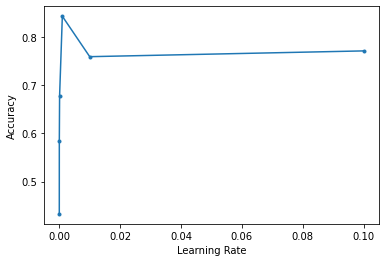

In [123]:
# Graph results
plt.plot(learning_rate_list, final_accuracy_learning_list, label = "Predicted Accuracies", marker = ".")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

In [125]:
# Looks like best learning rate is .001, so now we will use this
# Run model using learning dropout rate
build_model_output = build_model(384, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 4.9209 - accuracy: 0.31 - ETA: 0s - loss: 2.5132 - accuracy: 0.57 - 0s 1ms/step - loss: 2.1505 - accuracy: 0.6132
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 0.8907 - accuracy: 0.68 - ETA: 0s - loss: 1.7039 - accuracy: 0.64 - 0s 969us/step - loss: 1.6035 - accuracy: 0.6536
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.5184 - accuracy: 0.62 - ETA: 0s - loss: 1.2230 - accuracy: 0.68 - 0s 998us/step - loss: 1.1669 - accuracy: 0.6940
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.75 - ETA: 0s - loss: 0.8446 - accuracy: 0.73 - 0s 961us/step - loss: 0.8403 - accuracy: 0.7362
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.78 - ETA: 0s - loss: 0.6881 - accuracy: 0.76 - 0s 1ms/step - loss: 0.6884 - accuracy: 0.7629
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.6918 - accurac

71/71 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.90 - ETA: 0s - loss: 0.3298 - accuracy: 0.85 - 0s 923us/step - loss: 0.3345 - accuracy: 0.8486
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.90 - ETA: 0s - loss: 0.3372 - accuracy: 0.83 - 0s 1ms/step - loss: 0.3407 - accuracy: 0.8406
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.84 - ETA: 0s - loss: 0.3332 - accuracy: 0.85 - 0s 1ms/step - loss: 0.3356 - accuracy: 0.8508
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.87 - ETA: 0s - loss: 0.3382 - accuracy: 0.84 - 0s 909us/step - loss: 0.3292 - accuracy: 0.8535
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.78 - ETA: 0s - loss: 0.3336 - accuracy: 0.84 - 0s 894us/step - loss: 0.3307 - accuracy: 0.8495
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.7

In [126]:
# Try different numbers of nodes - keeping dropout at .3 and learning rate at .001

#Loop through nodes
final_accuracy_node_list = []

for i in range(1, 550, 50):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 4.9893 - accuracy: 0.34 - ETA: 0s - loss: 5.3231 - accuracy: 0.59 - 0s 740us/step - loss: 5.3231 - accuracy: 0.5933
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 2.4102 - accuracy: 0.56 - 0s 663us/step - loss: 3.5062 - accuracy: 0.5853
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 2.0882 - accuracy: 0.68 - 0s 655us/step - loss: 1.6283 - accuracy: 0.5977
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 1.0016 - accuracy: 0.59 - 0s 644us/step - loss: 0.7869 - accuracy: 0.5733
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.68 - ETA: 0s - loss: 0.6720 - accuracy: 0.60 - 0s 1ms/step - loss: 0.6754 - accuracy: 0.5955
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.53 - 0s 696us/step - loss: 0.6757 - accuracy: 0.5955
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss

71/71 [==============================] - ETA: 0s - loss: 3.3137 - accuracy: 0.53 - ETA: 0s - loss: 1.8945 - accuracy: 0.66 - 0s 927us/step - loss: 1.7954 - accuracy: 0.6670
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 2.7266 - accuracy: 0.59 - ETA: 0s - loss: 1.3116 - accuracy: 0.70 - 0s 940us/step - loss: 1.3434 - accuracy: 0.7029
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 1.3556 - accuracy: 0.68 - ETA: 0s - loss: 1.1533 - accuracy: 0.71 - 0s 916us/step - loss: 1.1290 - accuracy: 0.7189
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.9805 - accuracy: 0.65 - ETA: 0s - loss: 0.8259 - accuracy: 0.74 - 0s 908us/step - loss: 0.8138 - accuracy: 0.7531
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.96 - ETA: 0s - loss: 0.6890 - accuracy: 0.76 - 0s 922us/step - loss: 0.6852 - accuracy: 0.7660
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.78

Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.5788 - accuracy: 0.75 - ETA: 0s - loss: 0.8119 - accuracy: 0.74 - 0s 1ms/step - loss: 0.8036 - accuracy: 0.7473
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.81 - ETA: 0s - loss: 0.6519 - accuracy: 0.78 - 0s 912us/step - loss: 0.6645 - accuracy: 0.7780
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.81 - ETA: 0s - loss: 0.5653 - accuracy: 0.77 - 0s 1ms/step - loss: 0.5781 - accuracy: 0.7789
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.68 - ETA: 0s - loss: 0.5185 - accuracy: 0.79 - 0s 993us/step - loss: 0.5122 - accuracy: 0.7917
Epoch 9/10
71/71 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.87 - ETA: 0s - loss: 0.4674 - accuracy: 0.80 - 0s 953us/step - loss: 0.4566 - accuracy: 0.8108
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.3696 - accura

Text(0, 0.5, 'Accuracy')

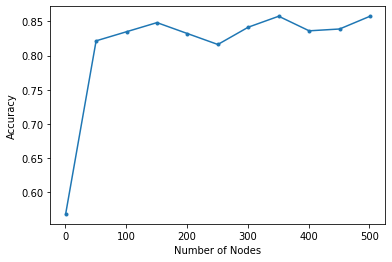

In [127]:
#Graph the results
plt.plot(range(1,550,50), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [129]:
# It looks like best value is somewhere between 300 and 450
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(300, 450, 25):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 3.6420 - accuracy: 0.68 - ETA: 0s - loss: 2.9648 - accuracy: 0.57 - 0s 945us/step - loss: 2.8017 - accuracy: 0.5870
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 2.1983 - accuracy: 0.71 - ETA: 0s - loss: 1.8871 - accuracy: 0.63 - 0s 942us/step - loss: 1.7537 - accuracy: 0.6559
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.8225 - accuracy: 0.59 - ETA: 0s - loss: 1.3534 - accuracy: 0.69 - 0s 962us/step - loss: 1.3627 - accuracy: 0.6914
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 1.4792 - accuracy: 0.62 - ETA: 0s - loss: 1.1365 - accuracy: 0.71 - 0s 948us/step - loss: 1.0587 - accuracy: 0.7225
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.78 - ETA: 0s - loss: 0.8053 - accuracy: 0.75 - 0s 1ms/step - loss: 0.7784 - accuracy: 0.7549
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.9414 - accur

Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.75 - ETA: 0s - loss: 1.1882 - accuracy: 0.68 - 0s 987us/step - loss: 1.1535 - accuracy: 0.6914
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.8145 - accuracy: 0.71 - ETA: 0s - loss: 0.9512 - accuracy: 0.73 - 0s 957us/step - loss: 0.9591 - accuracy: 0.7296
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.9456 - accuracy: 0.75 - ETA: 0s - loss: 0.8283 - accuracy: 0.73 - 0s 890us/step - loss: 0.7932 - accuracy: 0.7438
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.84 - ETA: 0s - loss: 0.6652 - accuracy: 0.76 - 0s 896us/step - loss: 0.6566 - accuracy: 0.7687
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.90 - ETA: 0s - loss: 0.5605 - accuracy: 0.78 - 0s 890us/step - loss: 0.5677 - accuracy: 0.7789
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.4748 - acc

Text(0, 0.5, 'Accuracy')

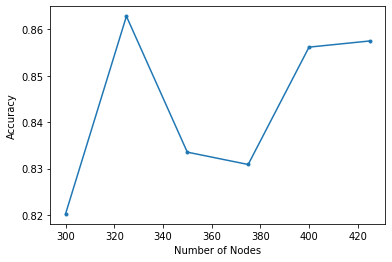

In [130]:
#Graph results
plt.plot(range(300, 450, 25), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [131]:
# It looks like best value is somewhere between 375 and 425
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(375, 425, 10):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 14.5004 - accuracy: 0.281 - ETA: 0s - loss: 3.1540 - accuracy: 0.568 - 0s 954us/step - loss: 2.9814 - accuracy: 0.5742
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 3.3051 - accuracy: 0.46 - ETA: 0s - loss: 2.0453 - accuracy: 0.63 - 0s 947us/step - loss: 2.0029 - accuracy: 0.6372
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.1384 - accuracy: 0.62 - ETA: 0s - loss: 1.4212 - accuracy: 0.66 - 0s 917us/step - loss: 1.4114 - accuracy: 0.6665
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 1.2318 - accuracy: 0.78 - ETA: 0s - loss: 1.1224 - accuracy: 0.71 - 0s 922us/step - loss: 1.0912 - accuracy: 0.7176
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 1.0773 - accuracy: 0.68 - ETA: 0s - loss: 0.8840 - accuracy: 0.74 - 0s 937us/step - loss: 0.8689 - accuracy: 0.7433
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.7432 - 

Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.1882 - accuracy: 0.68 - ETA: 0s - loss: 1.4137 - accuracy: 0.67 - 0s 962us/step - loss: 1.3195 - accuracy: 0.6865
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 1.4150 - accuracy: 0.68 - ETA: 0s - loss: 1.0165 - accuracy: 0.71 - 0s 941us/step - loss: 0.9948 - accuracy: 0.7154
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.87 - ETA: 0s - loss: 0.7651 - accuracy: 0.74 - 0s 921us/step - loss: 0.7920 - accuracy: 0.7487
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 1.4511 - accuracy: 0.75 - ETA: 0s - loss: 0.6924 - accuracy: 0.77 - 0s 904us/step - loss: 0.6773 - accuracy: 0.7753
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.4102 - accuracy: 0.84 - ETA: 0s - loss: 0.5751 - accuracy: 0.77 - 0s 979us/step - loss: 0.5587 - accuracy: 0.7820
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.7652 - acc

Text(0, 0.5, 'Accuracy')

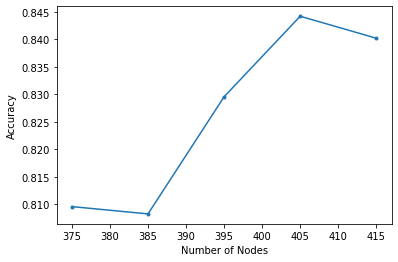

In [132]:
#Graph results
plt.plot(range(375, 425, 10), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [137]:
# It looks like best value is somewhere between 400 and 410
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(400, 410, 1):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 2.1041 - accuracy: 0.62 - ETA: 0s - loss: 2.5790 - accuracy: 0.58 - 0s 1ms/step - loss: 2.4566 - accuracy: 0.5910
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.75 - ETA: 0s - loss: 1.9586 - accuracy: 0.64 - 0s 952us/step - loss: 1.8930 - accuracy: 0.6474
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 2.4989 - accuracy: 0.56 - ETA: 0s - loss: 1.3963 - accuracy: 0.70 - 0s 947us/step - loss: 1.3727 - accuracy: 0.6954
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 1.2776 - accuracy: 0.65 - ETA: 0s - loss: 1.0408 - accuracy: 0.72 - 0s 1ms/step - loss: 1.0063 - accuracy: 0.7269
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.75 - ETA: 0s - loss: 0.8879 - accuracy: 0.73 - 0s 979us/step - loss: 0.9231 - accuracy: 0.7251
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.7666 - accurac

Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 2.1319 - accuracy: 0.62 - ETA: 0s - loss: 1.2176 - accuracy: 0.70 - 0s 992us/step - loss: 1.1986 - accuracy: 0.6972
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.8764 - accuracy: 0.65 - ETA: 0s - loss: 0.9848 - accuracy: 0.72 - 0s 946us/step - loss: 0.9385 - accuracy: 0.7251
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.84 - ETA: 0s - loss: 0.7354 - accuracy: 0.76 - 0s 905us/step - loss: 0.7152 - accuracy: 0.7709
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.78 - ETA: 0s - loss: 0.6857 - accuracy: 0.75 - 0s 960us/step - loss: 0.6702 - accuracy: 0.7575
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.71 - ETA: 0s - loss: 0.5829 - accuracy: 0.77 - 0s 1ms/step - loss: 0.5664 - accuracy: 0.7829
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.4743 - accur

Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.9592 - accuracy: 0.65 - ETA: 0s - loss: 0.8333 - accuracy: 0.74 - 0s 941us/step - loss: 0.8339 - accuracy: 0.7442
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.81 - ETA: 0s - loss: 0.6954 - accuracy: 0.76 - 0s 919us/step - loss: 0.6690 - accuracy: 0.7642
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.59 - ETA: 0s - loss: 0.6042 - accuracy: 0.77 - 0s 952us/step - loss: 0.6016 - accuracy: 0.7718
Epoch 8/10
71/71 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.75 - ETA: 0s - loss: 0.5545 - accuracy: 0.77 - 0s 986us/step - loss: 0.5446 - accuracy: 0.7842
Epoch 9/10
71/71 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.75 - ETA: 0s - loss: 0.5168 - accuracy: 0.78 - 0s 969us/step - loss: 0.4972 - accuracy: 0.7926
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.3404 - ac

Text(0, 0.5, 'Accuracy')

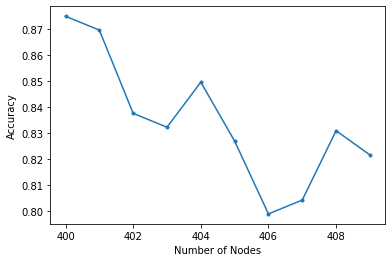

In [138]:
#Graph results
plt.plot(range(400, 410, 1), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [146]:
#Best value is 400. Re-run model with this value and 50 epochs, since we have tuned all the parameters.
build_model_output = build_model(400, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 3.3529 - accuracy: 0.50 - ETA: 0s - loss: 2.5659 - accuracy: 0.59 - 0s 945us/step - loss: 2.4555 - accuracy: 0.6008
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 1.8366 - accuracy: 0.56 - ETA: 0s - loss: 1.6823 - accuracy: 0.66 - 0s 932us/step - loss: 1.5961 - accuracy: 0.6736
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.0956 - accuracy: 0.71 - ETA: 0s - loss: 1.3168 - accuracy: 0.69 - 0s 953us/step - loss: 1.2742 - accuracy: 0.6980
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.71 - ETA: 0s - loss: 0.9930 - accuracy: 0.71 - 0s 937us/step - loss: 0.9721 - accuracy: 0.7202
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.75 - ETA: 0s - loss: 0.8086 - accuracy: 0.73 - 0s 941us/step - loss: 0.7856 - accuracy: 0.7447
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.9863 - acc

71/71 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.81 - ETA: 0s - loss: 0.3273 - accuracy: 0.85 - 0s 1ms/step - loss: 0.3346 - accuracy: 0.8508
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.75 - ETA: 0s - loss: 0.3331 - accuracy: 0.84 - 0s 1ms/step - loss: 0.3376 - accuracy: 0.8441
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.87 - ETA: 0s - loss: 0.3237 - accuracy: 0.86 - 0s 931us/step - loss: 0.3318 - accuracy: 0.8521
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.87 - ETA: 0s - loss: 0.3364 - accuracy: 0.84 - 0s 1ms/step - loss: 0.3341 - accuracy: 0.8499
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.81 - ETA: 0s - loss: 0.3420 - accuracy: 0.84 - 0s 899us/step - loss: 0.3328 - accuracy: 0.8495
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.90 

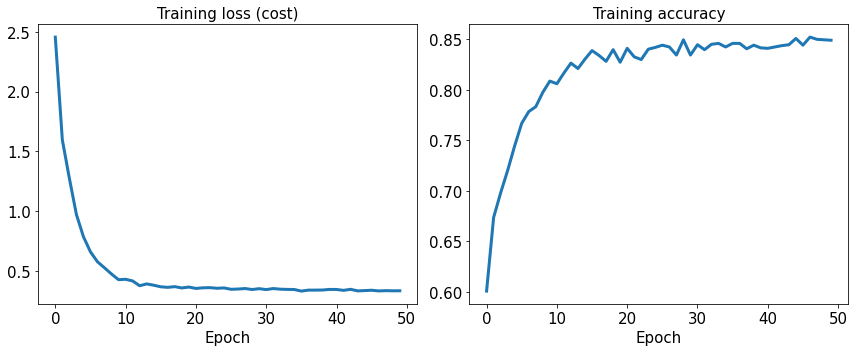

In [147]:
# Plot training cost and accuracy
hist = fit_model_output.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

**Conclusions**